# Regression Trees

## Linear Regression

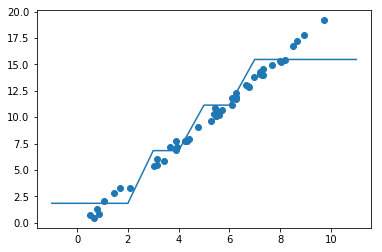

R^2 score: 0.9327616614063525


In [13]:
# generate the data
import matplotlib.pyplot as plt
import random
import pandas
x = pandas.DataFrame([10 * random.random() for __ in range(50)])
y = 2 * x - 1 + pandas.DataFrame([random.random() for __ in range(50)])

# pick model
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=2)
model.fit(x, y)

# plot the model together with the data
xfit = pandas.DataFrame([i for i in range(-1, 12)])
yfit = model.predict(xfit)
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.show()

# compute the R^2 score – good models: R^2 approx. 1
#print("R^2 score: {0:.2f}".format(model.score(x,y)))
print("R^2 score: {}".format(model.score(x,y)))

## Non-linear Regression

Choose a number for tree depth: 20
R^2 score: 1.00


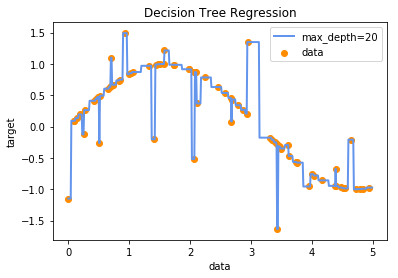

In [18]:
depth  = int(input('Choose a number for tree depth: '))

# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=depth)
regr_1.fit(X, y)
print("R^2 score: {0:.2f}".format(regr_1.score(X,y)))

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth="+str(depth), linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Grid Search

Best parameters: {'max_depth': 7}
R^2 score: 0.99


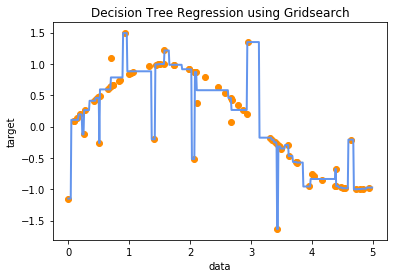

In [19]:
# Import the necessary modules and libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16)) # noise every 5th point

# setting up grid search
model = model = DecisionTreeRegressor()
param_grid = {'max_depth': list(range(1,25))}
grid = GridSearchCV(model, param_grid, cv=5)

# performing grid search
grid.fit(X,y)

# print out what we found
print("Best parameters: {}".format(grid.best_params_))

# Predict
regr_1 = grid.best_estimator_
print("R^2 score: {0:.2f}".format(regr_1.score(X,y)))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="darkorange")
plt.plot(X_test, y_1, color="cornflowerblue", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression using Gridsearch")
plt.show()

# K-NN Regression

## Linear Regression

Choose a number for k: 10
R^2 score: 0.99


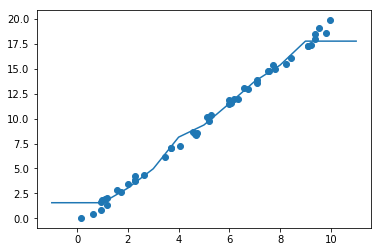

In [22]:
# generate the data
import matplotlib.pyplot as plt
import random
import pandas
n  = int(input('Choose a number for k: '))

x = pandas.DataFrame([10 * random.random() for __ in range(50)])
y = 2 * x - 1 + pandas.DataFrame([random.random() for __ in range(50)])

# pick model
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=n)
model.fit(x, y)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model.score(x,y)))

# plot the model together with the data
xfit = pandas.DataFrame([i for i in range(-1, 12)])
yfit = model.predict(xfit)
plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.show()

## Non-linear Regression

Choose a number for k: 1
R^2 score: 1.00


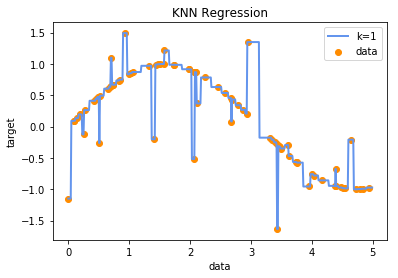

In [25]:
n  = int(input('Choose a number for k: '))

# Import the necessary modules and libraries
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = KNeighborsRegressor(n_neighbors=n)
regr_1.fit(X, y)
print("R^2 score: {0:.2f}".format(regr_1.score(X,y)))

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="k="+str(n), linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("KNN Regression")
plt.legend()
plt.show()

## Grid Search

Best parameters: {'n_neighbors': 1}
R^2 score: 1.0


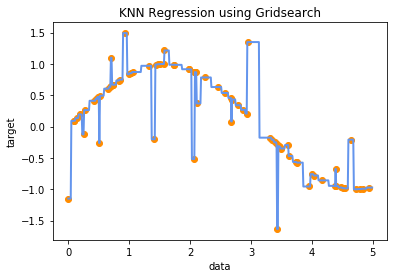

In [6]:
# Import the necessary modules and libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16)) # noise every 5th point

# setting up grid search
model = KNeighborsRegressor()
param_grid = {'n_neighbors': list(range(1,11))}
grid = GridSearchCV(model, param_grid, cv=5)

# performing grid search
grid.fit(X,y)

# print out what we found
print("Best parameters: {}".format(grid.best_params_))

# Predict
regr_1 = grid.best_estimator_
print("R^2 score: {}".format(regr_1.score(X,y)))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="darkorange")
plt.plot(X_test, y_1, color="cornflowerblue", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("KNN Regression using Gridsearch")
plt.show()

# MLP

## Linear Regression

Choose a number for hidden nodes: 2


/Users/lutz/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R^2 score: 0.99


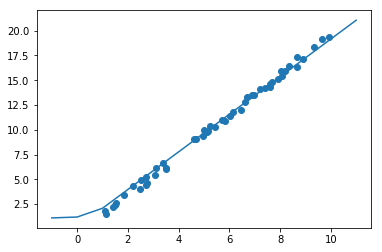

In [29]:
# generate the data
import matplotlib.pyplot as plt
import random
import pandas

n  = int(input('Choose a number for hidden nodes: '))

X = pandas.DataFrame([10 * random.random() for __ in range(50)])
y = 2 * X - 1 + pandas.DataFrame([random.random() for __ in range(50)])

# pick model
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(n,),
                     activation='relu', max_iter=10000)
model.fit(X, y)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model.score(X,y)))

# plot the model together with the data
Xfit = pandas.DataFrame([i for i in range(-1, 12)])
yfit = model.predict(Xfit)
plt.scatter(X, y)
plt.plot(Xfit, yfit)
plt.show()


## Non-linear Regression

Choose a number for hidden nodes: 10
R^2 score: 0.7574970768018181


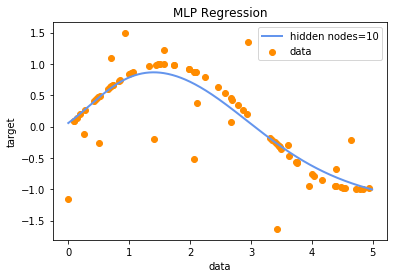

In [35]:

n  = int(input('Choose a number for hidden nodes: '))

# Import the necessary modules and libraries
import numpy as np
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = MLPRegressor(hidden_layer_sizes=(n,3), activation='tanh', max_iter=10000)
#regr_1 = MLPRegressor(hidden_layer_sizes=(n,n),  max_iter=10000)
regr_1.fit(X, y)
print("R^2 score: {}".format(regr_1.score(X,y)))

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="hidden nodes="+str(n), linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("MLP Regression")
plt.legend()
plt.show()